<a href="https://colab.research.google.com/github/pulseq/MR-Physics-with-Pulseq/blob/main/tutorials/07_echo_planar_imaging/notebooks/03_from_basic_to_more_advanced_EPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Towards more advanced EPI sequence

For the first-time use select Runtime->Run All (or hit Ctrl+F9) as thie initial setup of the environment takes about a minute. In a mean time scroll down to familiarize yourself with the sequence code.

**Simulations with MR0 is not compatible with more advanced features of this notebook, therefore they were removed**

The exercises are at the at of the notebook

# Initial package set-up
This is a necessary step for the Colab environment, and it is only slow on the first run

In [ ]:
try:
  import pypulseq as mr
  print("pypulseq package is readily available\n")

except ImportError or ModuleNotFoundError:
  #!pip install git+https://github.com/imr-framework/pypulseq.git
  !pip install git+https://github.com/FrankZijlstra/pypulseq.git@bugfixes
  #!pip install -q mrzerocore git+https://github.com/imr-framework/pypulseq.git
  # Frank's utils
  !wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py

# Python imports

In [ ]:
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt

import pypulseq as mr

# Frank's utils
from utils import animate, simulate_2d, reconstruct

# Set high-level sequence parameters
Use the code block below to set high-level parameters such as FOV, spatial resolution, etc...

In [ ]:
# Define FOV, resolution and other parameters
fov = 220e-3
Nx = 60
Ny = 60
slice_thickness = 4e-3  # Slice thickness
n_slices = 1
ro_duration=1200e-6 # duration of the ADC / readout event, defailt: 1200us, 240us still works
rf_duration=2.5e-3
pe_switch = 1 # 1, 0 or -1 -- option to disable or invert phase encoding

# Set system limits
system = mr.Opts(
    max_grad=32,
    grad_unit="mT/m",
    max_slew=130,
    slew_unit="T/m/s",
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

# More advansed options and switches. you may chose to disable some of these options to save time in the exercises
plot: bool = True
write_seq: bool = True
seq_filename: str = "epi_pypulseq.seq"

# Create Pulseq objects
Create all kinds of objects that we will need in the sequence, such as the slice selective RF pulse, slice selection and refocusing gradients, etc...

In [ ]:
# Create 90 degree slice selection pulse and gradient
rf, gz, gz_reph = mr.make_sinc_pulse(
    flip_angle=np.pi / 2,
    system=system,
    duration=rf_duration,
    slice_thickness=slice_thickness,
    apodization=0.5,
    time_bw_product=4,
    return_gz=True,
)

# Define other gradients and ADC events
delta_k = 1 / fov
k_width = Nx * delta_k
dwell_time = ro_duration / Nx
flat_time = np.ceil(ro_duration / system.grad_raster_time) * system.grad_raster_time  # round-up to the gradient raster
gx = mr.make_trapezoid(
    channel="x",
    system=system,
    amplitude=k_width / ro_duration,
    flat_time=flat_time,
)
adc = mr.make_adc(
    num_samples=Nx,
    duration=ro_duration,
    delay=gx.rise_time + flat_time / 2 - (dwell_time*Nx) / 2,
    system=system,
)

# Pre-phasing gradients (in the shortest possible time or filling the available time)
gx_pre = mr.make_trapezoid(
    channel="x", system=system, area=-gx.area / 2, duration=mr.calc_duration(gz_reph),
)
gy_pre = mr.make_trapezoid(
    channel="y", system=system, area=(Ny / 2 - 1) * delta_k * pe_switch, duration=mr.calc_duration(gz_reph),
)

# align gradients (calculate their delays)
gx_pre, gy_pre, gz_reph=mr.align(right=[gx_pre],left=[gy_pre, gz_reph])

# Phase blip in the shortest possible time (assuming a triangle is possible)
dur = np.ceil(2 * np.sqrt(delta_k / system.max_slew) / system.grad_raster_time) * system.grad_raster_time
gy = mr.make_trapezoid(channel="y", system=system, area=-delta_k * pe_switch, duration=dur)

print('achieved echo spacing is {}us'.format(round(1e6*(mr.calc_duration(gx)+mr.calc_duration(gy)))))

# Construct the sequence
Contruct the sequence object and fill it up block-by-block

In [ ]:
seq = mr.Sequence(system)  # Create a new sequence object

# populate the sequence object with event blocks
for s in range(n_slices):
  rf.freq_offset = gz.amplitude * slice_thickness * (s - (n_slices - 1) / 2)
  seq.add_block(rf, gz)
  seq.add_block(gx_pre, gy_pre, gz_reph)
  gx_curr=gx
  for i in range(Ny):
    seq.add_block(gx_curr, adc)  # Read one line of k-space out
    if i!=Ny-1:
      seq.add_block(gy)  # Phase blip
      gx_curr = mr.scale_grad(gx_curr,-1)  # Reverse polarity of read gradient

# Timing check
Check whether the sequence timing is OK and the objects are consistent and compatible with each other and the target scanner

In [ ]:
(
    ok,
    error_report,
) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# Visualize the sequence
Here we just plot the sequence timing. Due to the limitations of the Colab environment the plots are not live, no interactive zoom-in / zoom-out is possible, therefore it is necessary to use the time_range option

In [ ]:
if plot:
  print("Plot the beginning of the sequence")
  #seq.plot(time_range=[0, 5.22e-3], time_disp="us", show_blocks=True) # just a small initial part
  seq.plot(time_range=[0, 8e-3], time_disp="ms")

  #
  print("Plot of the entire sequence")
  seq.plot() # plot the entire sequence

In [ ]:
[k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc] = seq.calculate_kspace()
plt.figure(figsize=(10, 10))
plt.plot(k_traj[0,],k_traj[1,], 'b-')
plt.plot(k_traj_adc[0,],k_traj_adc[1,], 'r.')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('k-space trajectory')
plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
plt.draw()

# (Optionally) Analyze the sequence
Very optional slow step, but useful for testing during development
e.g. for the real TE, TR or for staying within slew-rate limits, etc.

In [ ]:
rep = seq.test_report()
print(rep)

#Write the .seq file

Set the output parameters (definitions) and write the sequence to the file.

*Note: The FOV definition is also used by the simulation/reconstruction code below*

In [ ]:
# Prepare the sequence output for the scanner
seq.set_definition(key="FOV", value=[fov, fov, slice_thickness*n_slices])
seq.set_definition(key="Name", value="epi")

if write_seq:
  # Write the sequence file
  seq.write(seq_filename)
  from google.colab import files
  files.download(seq_filename)  # Download locally

# Exercises (from basic to more advanced EPI)
Here you find a list of the proposed exercises, explanations and code snippets can be found below.
1. add fat suration
2. add distortion visualization (as an SMS pulse applied along Y direction followed by a spoiler, or alternatively a set of slices). Load and reconstruct data with varying ro_bandwidth / echo spacing & pe_direction
3. add ramp sampling
Once done, proceed to the experimental part (exercise 04) to reconstruct experimental data with and without fat saturation, with distortion visualisation, etc.

#Exercise 1: fat taturation

As briefly shown in the presentation, fat signals present a substantial challenge for EPI. With typical settings fat signal appears displaced by about 1/4 of the FOV in the phase-encoding dimension, typically overlapping with the anatomy of interest.

The most basic fat saturation approach consists in introducing a frequency-selective RF pulse followed by a spoiler gradient. This pulse is designed to primarily saturate the fat signals while leaving water protons largely unaffected. This is possible due to a substantial chemical shift between water and fat (about 3.3 to 3.5 ppm). In fact, the fat resonance in vivo is quite broad, therefore there are a variety of values that can be found in the literature. Also different RF pulses can be employed for fat saturation, in this example we choose a Gaussian pulse. To achieve a more complete saturation we overflip the magnetization beyond 90° (110° is known to work well).


#Exercise 1 hints
The code in the following cell can be used to generate the respective pulses.

*Note how the area of the spoiler gradient is calculated.* Can you explain the physical meaning of the used values?

Then a block containing both these Pulseq objects can be added prior to the slice-selective RF excitation block in the sequence generation loop. Aim at something like:

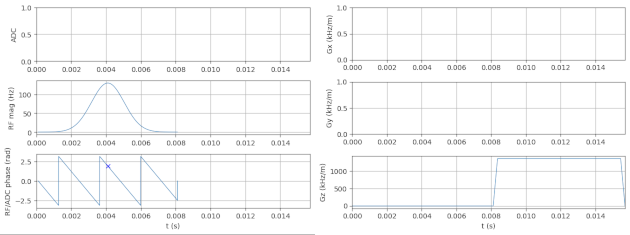

In [ ]:
sat_ppm = -3.45 # assumed fat resonance shift
B0 = 2.89       # this is Siemens' 3T :-)
sat_freq = sat_ppm * 1e-6 * B0 * system.gamma
# create RF pulse
rf_fs = mr.make_gauss_pulse(
    flip_angle=110 * np.pi / 180,
    system=system,
    duration=8e-3,
    bandwidth=np.abs(sat_freq),
    freq_offset=sat_freq,
    use='saturation',
)
# create spoiler gradient which can be played out in the same block
gz_fs = mr.make_trapezoid(
    channel="z", system=system, delay=mr.calc_duration(rf_fs), area=1/1e-4
)

#Exercise 2: saturation bands for distortion visualization
Phantoms with rectangular geometric structures, e.g. with bars or grids, can be used for visualizing geometric distortions in EPI. However such phantoms may be unavailable and/or expensive, especially bearing in mind that the phantom should have favorable magnetic homogeniety propperties, e.g. all materials should have magnetic susceptibility close to that of whater and the overall shape should be spherical or cylindrical. Additionally, for an appealing visual apearence it might be desirable to aling the phantom to the image encoding coordinates.

A viable alternative to that is to create the desired features in the images of a homogeneous water phantom by applying appropriate preparation pulses.  This exercise consists of three steps:

1. creating a multiband excitation pulse and applying it in combination with a slice-slection gradient along the PE dimention of the EPI readout
2. creaing a combined gradient pulse including the slice selection gradient and a spoiler gradient to make it compatible with a single Pulseq block
3. adding a corresponding block to the sequence generation loop prior to the excitation (or prior to the fat saturation)

#Exercise 2 hint 1
Although one could use the SMS/multiband pulse generation routine from the RF Design course on Day 1, here we propose to create a multiband pulse from single slices manually. We rely on the small tip angle approximation, which si sufficient for our purposes (achieving a reasonable visual appearance).

The original pulse shape needs to be frequency and phase modulated to achieve shifted slice excitation and the resulted modulated pulses need to be added all together. The modulation frequency required to achieve desired slice shifts can conviniently be extracted from the slice selection gradient.

In [ ]:
mb_thick=6e-3  # thinckness of the saturated bands
mb_step=30e-3  # spacing between the centers of the bands
mb_rf_dur=5e-3 # duration of the RF pulse
mb_count=5     # number of bands

# create the initial pulse
rf_mb, gy_mb, _ = mr.make_sinc_pulse(
    flip_angle=np.pi / 2,
    system=system,
    duration=mb_rf_dur,
    slice_thickness=mb_thick,
    apodization=0.5,
    time_bw_product=4,
    use='saturation',
    return_gz=True,
)
gy_mb.channel='y' # need to fix the channel for the gradient pulse
# create a modulated shape
mb_s=np.zeros_like(rf_mb.signal,dtype=np.complex128)
tc,_=mr.calc_rf_center(rf_mb)
for o in range(mb_count):
  # calculate frequency offset. we use the amplitude of the slice selection gradient generated above (which is in units of Hz/m) to convert mb_step to the frequency domain
  fo = gy_mb.amplitude * mb_step * (o - (mb_count - 1) / 2)
  # phase offset is optional in the context of this exercise and is a bit of a 'cream on top of the cake' - it just allows to redice the peak amplitude / SAR
  po = np.pi*(o-(mb_count-1)/2) - 2*np.pi*fo*tc

  s = rf_mb.signal*np.exp(1j*(2*np.pi*fo*rf_mb.t + po))

  mb_s += rf_mb.signal*np.exp(1j*(2*np.pi*fo*rf_mb.t + po))
# replace the original shape with a modulated one
rf_mb.signal=mb_s

In [ ]:
# just a preview of the multiband saturation block, this code is should not be copied to the final sequence
seq1 = mr.Sequence(system)
seq1.add_block(rf_mb,gy_mb)
seq1.plot()
del seq1

#Exercise 2 hint 2
Although not strictly needed in this sequence from the MR pysics perspective, let us take an occasion to demonstrate a gradient surgery technique of Pulseq. Here, you can use the readily available slice selection gradient and calculate the additional spoiler gradient with a desired area to be attached to the back of the slice gradient.

In [ ]:
# create the spoler gradient. we will not use it directly, thus the suffix 'tmp'
gy_mb_tmp1,_,_=mr.make_extended_trapezoid_area(area=1/1e-4, channel='y', grad_start=gy_mb.amplitude, grad_end=0, system=system)
gy_mb_tmp2=mr.split_gradient_at(grad=gy_mb, time_point=gy_mb.delay+gy_mb.rise_time+gy_mb.flat_time)[0] # we are only interested in the first part hense [0]
gy_mb_tmp1.delay=mr.calc_duration(gy_mb_tmp2)
gy_mb_comb=mr.add_gradients(grads=(gy_mb_tmp2,gy_mb_tmp1),system=system)

In [ ]:
# just a preview of the multiband saturation block, this code is should not be copied to the final sequence
seq1 = mr.Sequence(system)
seq1.add_block(rf_mb,gy_mb_comb)
seq1.plot()
del seq1

#Exercise 3: Optimized EPI readout with ramp sampling
The initial basic EPI sequence had two substantial shortcomings limiting the achievable echo spacing, $T_{ESP}$:
1. Phase encoding blips were placed into separate blocks
2. ADC was on only during the flat part of the readout gradient

We address the first issue by temporally overlapping blips with the ramps of the readout gradients. To achieve a symmetrical solution a half of the blip needs to be played out during the ramp down of the *current* readout gradient, whereas the other half follows at the time of the next readout ramp up. Another way of looking at it is to see the readout gradient as a continous wave and the blips are centered around the time when the readout gradient amplitude crosses zero.

Ramp sampling is a technique for improving ADC sampling efficieny in situations when strong gradients are used for signal readout, e.g. in EPI or in ultra-short TE (UTE) imaging.

Calculation of the readout gradient for EPI with ramp sampling is quite tricky. On one hand the readout gradient is a simple trapezoid, but the both freon and tail parts of this trapezoid need to be excluded from sampling (and correspondingly the area calculation) because these times are taken by the two halves of the blip gradients. Due to the fact that the *vortexes* and the total duration of trapezoid need to be aligned to the gradient raster time, the precise calculation of such truncated trapezoid gradient can only be done numerically. To aid educational objectives of this course we propose another approach, which may potentially result in some minor departures of the most optiml timing. The algorithm is as follows:

1. calculate timing of the blip assuming it is devisible into two equal parts both aligned to the gradient raster
2. estimate the area under two corners of the trapezoid (beginning and end) that are overlapped by the blips assuming that the readout gradient is ramping up from 0 at the maximum system rate (or ramping down to 0 at the same rate)
3. create a shortest possible trapezoid with the area corresponding to the covered k-space extent **plus the area calculated in the point#2 above**
4. due to the rounding up to the gradient raster, the ramps of the gradient produced in point#3 are likely to be somewhat slower than the initially assumed maximum slew rate (see point#2). Therefore the area under the truncated trapezoid is likely a bit larger than required, which can be corrected by scaling the gradient aplitude down without changing its timing

Now that the timing of the readout gradient has been defined, it is possible to finish the calculation of the blips. At this point it is reasonable to notice that Pulseq block boundaries may cross gradients at non-zero values but cannot cross ADC objects (or RF pulses). Bearing in mind that ADC objects are surrounded by dead times on the order of 20$\mu$s, the most straigtforward block structure is to align blocks with the readout gradient zero points. It is then clear that the blips need to be split in halves.

If we consider one gradient echo period in the middle of the gradient echo train, we notice that the PE gradient starts at the PE blip amplitude, ramps down to 0 and then ramps up back to the PE blip amplitude after the ADC sampling period. Such gradient object, although atypical in Siemens IDEA and on many other platforms, si completely normal in Pulseq and can be created by mr.make_extended_trapezoid() or by adding two gradient part using the mr.add_gradients() function. Note that for the first gradient echo the ramp-down part at the beginning has to be skipped. Similarly, for the last gradient echo the blip-ramp-up part needs to be skipped.

The ADC object calculation is also quite trickly. As we use ramp sampling, so we have to calculate the dwell time and the number of samples, which are will be quite different from $N_x$ and $T_{readout}/N_x$, respectively.
On goal is fullfill the Nyquist condition at the time when the readout gradient reaches its full amplitude, so the dwell time can be estimated from the desireg k-space step and the gradient amplitude, followed by a ramp-down to the ADC raster time. Thereafter the number of samples can be calculated to fill the specified readout duration. BTW, there may me platform-specific limitations applicable at this point, for instance on Siemens the number of ADC samples must be divisible by 4.

#Exercise 3 hint 1
here you may find a code example implementing the above logic for the redout gradient

In [ ]:
# Phase blip in shortest possible time (assuming a triangle is possible)
# This time rounding up the duration to 2x gradient raster time to make sure it can be split in two halves
blip_duration = np.ceil(2 * np.sqrt(delta_k / system.max_slew) / system.grad_raster_time / 2) * system.grad_raster_time * 2
gy = mr.make_trapezoid(channel="y", system=system, area=-delta_k, duration=blip_duration)

# Readout gradient is a truncated trapezoid with dead times at the beginning and at the end each equal to a half of
# blip duration. The area between the blips should be defined by k_width. We do a two-step calculation: we first
# increase the area assuming maximum slew rate and then scale down the amplitude to fix the area
extra_area = blip_duration / 2 * blip_duration / 2 * system.max_slew
gx = mr.make_trapezoid(
   channel="x",
   system=system,
   area=k_width + extra_area,
   duration=ro_duration + blip_duration,
)
actual_area = gx.area - 2 * gx.amplitude / gx.rise_time * blip_duration / 2 * blip_duration / 2 / 2
gx=mr.scale_grad(gx, k_width/actual_area)

# Read pre-phasing gradient (filling the available time)
gx_pre = mr.make_trapezoid(
    channel="x", system=system, area=-gx.area / 2, duration=mr.calc_duration(gz_reph),
)

#Exercise 3 hint 2
Here is the code examplifying the ADC calculation

In [ ]:
# calculate ADC - it is quite trickly
# we use ramp sampling, so we have to calculate the dwell time and the
# number of samples, which are will be quite different from Nx and
# readoutTime/Nx, respectively.
adc_dwell_Nyquist=delta_k/gx.amplitude # dwell time on the top of the plato
# round-down dwell time to system.adcRasterTime (100 ns on Siemens)
adc_dwell=np.floor(adc_dwell_Nyquist/system.adc_raster_time)*system.adc_raster_time
adc_samples=np.floor(ro_duration/adc_dwell/4)*4 # on Siemens the number of ADC samples need to be divisible by 4
# it is open for discussion, whether the above line should use mp.floor(), np.round() or np.ceil(). The danger of the later two is that the duration of the ADC may grow beyond the duration of the truncated trapezoid and overlap with the blips
adc = mr.make_adc(num_samples=adc_samples, dwell=adc_dwell)

# realign the ADC with respect to the gradient
time_to_center=adc.dwell*(adc_samples/2) # Pulseq (and Siemens) define the samples to happen in the center of the dwell period
adc.delay=np.round((gx.rise_time+gx.flat_time/2-time_to_center)/system.rf_raster_time)*system.rf_raster_time
          # above we adjust the delay to align the trajectory with the gradient.
          # We have to aligh the delay to seq.rfRasterTime (1us)
          # this rounding actually makes the sampling points on odd and even readouts
          # to appear misalligned. However, on the real hardware this misalignment is
          # much stronger anyways due to the grdient delays

#Exercise 3 hint 3
To finish the blip gradient we use mr.split() and mr_add_gradients() functions. Of course, we need tto remember about the pe_switch functionality

In [ ]:
# finish the blip gradient calculation
# split the blip into two halves and produce a combined synthetic gradient
gy_blip_parts = mr.split_gradient_at(grad=gy, time_point=blip_duration/2, system=system)
gy_blip_up,gy_blip_down,_=mr.align(right=gy_blip_parts[0],left=(gy_blip_parts[1],gx))
# now for inner echos create a special gy gradient, that will ramp down to 0, stay at 0 for a while and ramp up again
gy_blip_down_up=mr.add_gradients(grads=(gy_blip_down, gy_blip_up), system=system)

# pe_switch support
gy_blip_up=mr.scale_grad(gy_blip_up,pe_switch);
gy_blip_down=mr.scale_grad(gy_blip_down,pe_switch);
gy_blip_down_up=mr.scale_grad(gy_blip_down_up,pe_switch);

print('achieved echo spacing is {}us'.format(round(1e6*mr.calc_duration(gx))))

#Exercise 3 hint 4

If you managed to make it here, you sould be able to implement the EPI sequence loop without further hints ;-)